# CREATE DATA OBJECT TWOPData to load ALL recording data
## The data basepath should contain
    - INTAN FILES
        - info.rhd
        - one of the following: amplifier_analogin_auxiliary_int16.dat, analogin.dat, (basename).dat

    - FACEMAP FILES
        - a ..._proc.npy file or ..._proc.mat file

    - SUITE2P FOLDER
        - folder containing preprocessed 'suite2p' folder
        - Experiment.xml file (containing scope fps, optional) -> can provide manually if you dont have

In [5]:
## Import data wrapper from main file 
from TwoPDataPipeline import TwoPData
import os 
%load_ext autoreload
%autoreload 2

# path to directory that contains all data files from recording
#data_basepath = '/mnt/Gianna_Mattessich/Arenski_Data/NGF_MMN/WT/WT7628/WT7628_day1'
data_basepath = '/mnt/Gianna_Mattessich/Arenski_Data/NGF_MMN/WT/WT7628/WT7628_day1'
# encapsulate and load data (intan signals, facemap, and suite2p outputs) into all_data variable for analysis use 
# if using default channels for 2P recordings, can just call 
#                                              all_data = TwoPData(data_basepath)
# when scope_fps is None, get scope fps from Experiment.xml file, else est from scope times
all_data = TwoPData(suite2p_basepath=data_basepath, intan_basepath=data_basepath, facemap_path=data_basepath,
                    twop_channel=2, pd_channel=5, camera_channel=3, treadmill_channel=6, scope_fps=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found scope fps (scope fs est = 1.366) from Experiment.xml file

Reading Intan Technologies RHD Data File, Version 1.5

Found 0 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 8 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Getting transitions from 0:7691.47195 s
Found 10400 raw triggers for scope
Did not fix alignment of scope and triggers.
Getting transitions from 0:7691.47195 s
Found 2348 raw triggers for photodiode
Getting transitions from 0:7691.47195 s
Found 229569 raw triggers for camera
Getting transitions from 0:7691.47195 s
Found 1347915 raw triggers for treadmill
Found facemap file path /mnt/Gianna_Mattessich/Arenski_Data/NGF_MMN/WT/WT7628/WT7628_day1/WT7628_10_21_24_Lamp5GCamp_V1_MMN_face_2024-10-21-155230-0000_proc.npy


##### Save to joblib to save time reloading all data later

In [ ]:
import joblib, os

data_output = os.path.join(data_basepath, 'twopdata.joblib')
if not os.path.exists(data_output):
    joblib.dump(all_data, data_output, compress=("lz4", 3))

##### Reload joblib file

joblib.load(data_output)

### Ex. Get a raw intan signal and its timings

##### Camera

In [6]:
camera_signal = all_data.camera_raw
camera_times = all_data.camera_times
print(f'Cam signal raw: {camera_signal}')
print(f'Camera trigger times: {camera_times}')

Cam signal raw: [3.24195561 3.29029641 3.29996457 ... 3.28385097 3.29996457 3.26693169]
Camera trigger times: [  31.2491    31.28505   31.32125 ... 7683.62565 7683.65895 7683.6923 ]


##### Treadmill

In [7]:
treadmill_signal = all_data.treadmill_raw
print(f'Treadmill signal raw: {treadmill_signal}')

Treadmill signal raw: [1.25605512 1.25202672 1.25202672 ... 1.2568608  1.2548466  1.25605512]


##### Scope

In [8]:
scope_times = all_data.scope_times
print(f'Scope trigger times: {scope_times}')

Scope trigger times: [  40.6442    41.37605   42.108   ... 7650.79205 7651.524   7652.25595]


## Get suite2p object from TwoPData
(created from class definition in getSuite2POutput)

In [9]:
suite2p_output = all_data.s2p_out

### Ex. get ΔF/F traces and save to CSV

In [5]:
import os 

deltaF_savepath = os.path.join(data_basepath, 'deltaF.csv')
# calc deltaF without saving -> 
#                              dff = suite2p_output.calc_deltaF(), see other possible params in getSuite2POutput.py

# deltaF function returns both dff array and estimated time array (1D). To get only dff, specify index 0 when defining
# get deltaF as numpy array
deltaF = suite2p_output.calc_deltaF(save_csv=deltaF_savepath)[0]

# load as dataframe
deltaF_dataframe = suite2p_output.calc_deltaF(output_df=True)[0]

# get neuropil spikes (optional)
deltaF_neuropils = suite2p_output.calc_deltaF(F_neuropil=True)[0]

deltaF_neuropils_dataframe = suite2p_output.calc_deltaF(F_neuropil=True, output_df=True)[0]

In [7]:
deltaF_dataframe.head().iloc[:, 0:5]

,0,1,2,3,4
0,0.000000,0.732064,1.464129,2.196193,2.928258
1,-0.083254,0.001216,0.079579,0.102273,0.012275
2,0.019921,0.296256,0.280696,0.007841,0.079952
3,0.075467,0.114184,0.126733,0.175848,0.088120
4,-0.023879,0.652193,0.333986,0.136503,0.097814


In [16]:
deltaF_neuropils_dataframe.head().iloc[:, 0:5]

,0,1,2,3,4
0,0.000000,0.732064,1.464129,2.196193,2.928258
1,-0.192842,0.017124,0.055907,0.244451,0.022444
2,0.035426,0.473022,0.442829,-0.004641,0.168350
3,0.131629,0.171367,0.178327,0.241303,0.117538
4,-0.021765,2.509089,1.147232,0.671692,0.454902


### Ex. get cell spikes

In [34]:
spikes_savepath = os.path.join(data_basepath, 'spikes.csv')
# get array of spikes and save to csv
spikes_arr = suite2p_output.get_cell_spikes(save_to_csv=True, output_filepath= spikes_savepath)
# get dataframe of spikes -> (num_cells, num_frames)
spikes_df = suite2p_output.get_cell_spikes(output_df=True)

In [6]:
# inspect dataframe
spikes_df.head().iloc[:, 0:5]

,0,1,2,3,4
0,0.0,50.765545,12.826757,22.856503,0.0
1,0.0,482.167542,0.000000,0.000000,0.0
2,0.0,78.417122,39.992268,51.504822,0.0
3,0.0,650.387573,0.000000,0.000000,0.0
4,0.0,19.674032,0.000000,0.000000,0.0


### Ex. get raw fluorescence, num cells, etc

In [22]:
print(f'Raw fluourescence {suite2p_output.F}')
print(f'Number cells {suite2p_output.num_cells}')

Raw fluourescence [[ 667.4568   723.71606  776.35187 ...  761.26544  821.4877   821.4877 ]
 [1036.7976  1288.4706  1274.3833  ... 1186.7699  1256.8241  1256.8241 ]
 [ 827.5935   855.89923  865.1357  ...  808.67596  910.91565  910.91565]
 ...
 [ 336.1732   340.5882   314.1919  ...  288.02185  314.32724  314.32724]
 [ 397.5971   411.43158  420.15482 ...  345.8997   348.80142  348.80142]
 [ 534.19476  621.2366   563.6658  ...  567.9311   404.02505  404.02505]]
Number cells 22


### Ex. calculate SNR

In [24]:
SNR = suite2p_output.get_SNR()
SNR

array([8.19631156, 4.92604073, 7.10638876, 5.9059258 , 6.32393358,
       6.95784123, 6.51636019, 6.16092114, 5.57617627, 5.96948139,
       5.78130782, 4.94434196, 5.51368487, 5.71862928, 4.37150727,
       5.35913393, 6.27719698, 5.31683845, 5.41480537, 5.16645741,
       5.69824067, 5.78965222])

### Ex. make some plots

(<Figure size 6000x500 with 5 Axes>,
 array([<Axes: ylabel='Cell 15'>, <Axes: ylabel='Cell 16'>,
        <Axes: ylabel='Cell 17'>, <Axes: ylabel='Cell 18'>,
        <Axes: xlabel='Frame', ylabel='Cell 19'>], dtype=object))

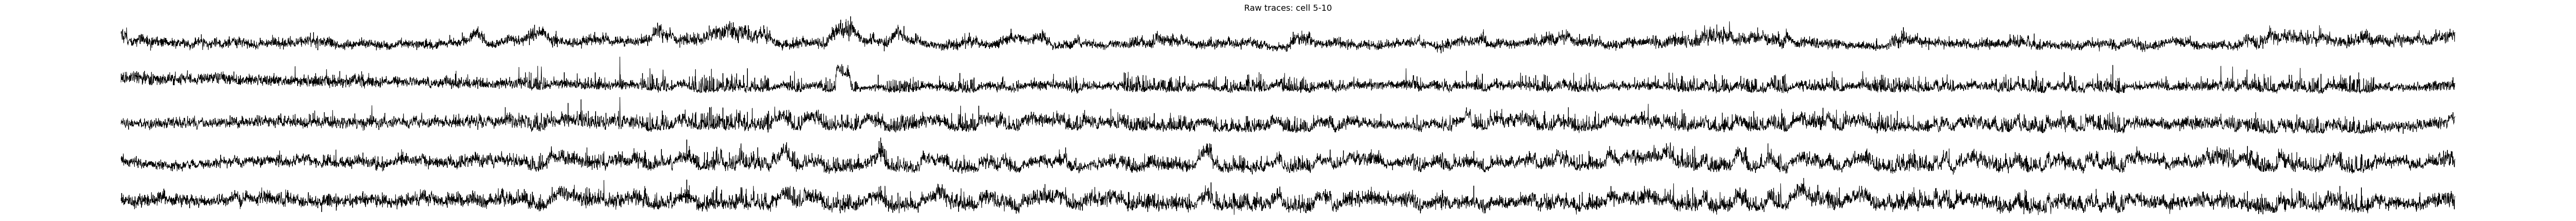

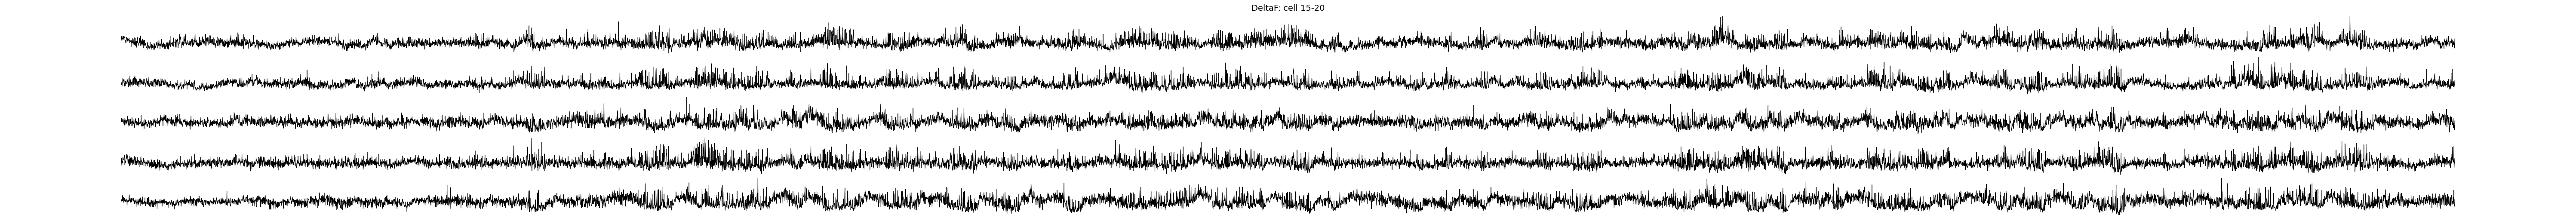

In [18]:
from twop.plots import *

# can specify cell range to plot
plot_raw_traces(suite2p_output, cell_range=[5,10], title='Raw traces: cell 5-10',**{'figsize':(60,5)})
plot_dff(suite2p_output, cell_range=[15, 20], title='DeltaF: cell 15-20',**{'figsize':(60,5)})

(<Figure size 6000x500 with 5 Axes>,
 array([<Axes: ylabel='Cell 0'>, <Axes: ylabel='Cell 1'>,
        <Axes: ylabel='Cell 2'>, <Axes: ylabel='Cell 3'>,
        <Axes: xlabel='Frame', ylabel='Cell 4'>], dtype=object))

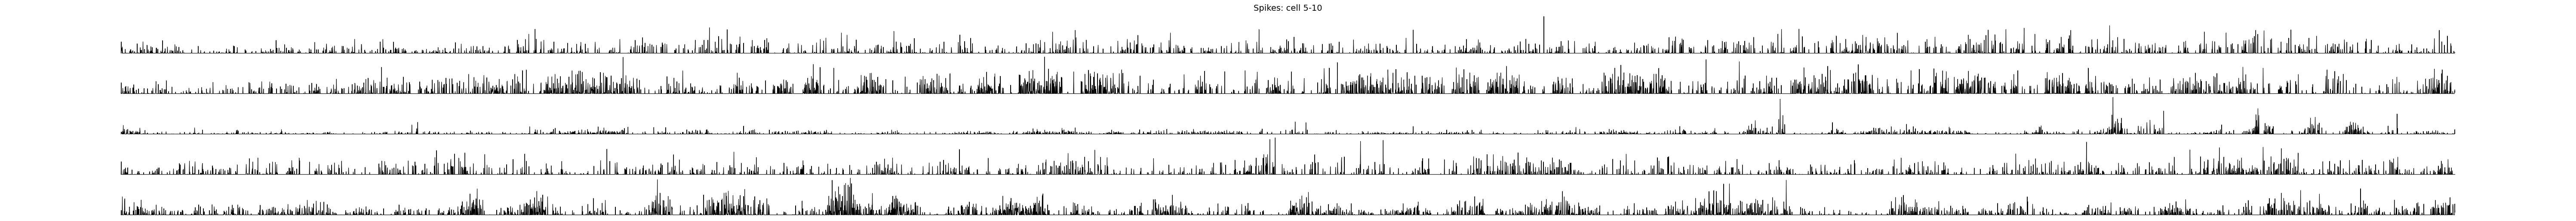

In [19]:
plot_spikes(suite2p_output, cell_range=[0, 5], title='Spikes: cell 5-10',**{'figsize':(60,5)})

<Axes: title={'center': 'Smoothed heatmap'}, xlabel='Frame (#)', ylabel='Cell (#, relative in range)'>

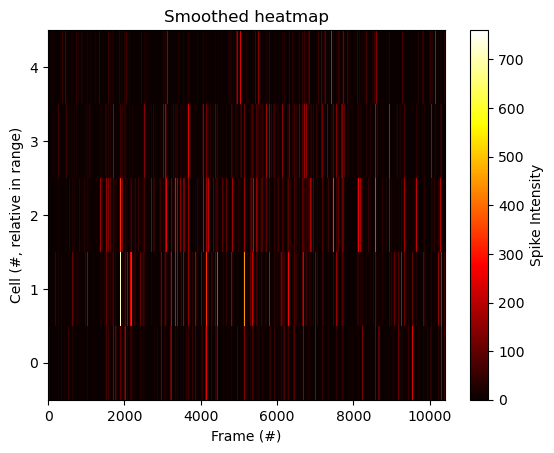

In [22]:
smoothed_event_plot(suite2p_output, cell_range=[5, 10], title='Smoothed heatmap')

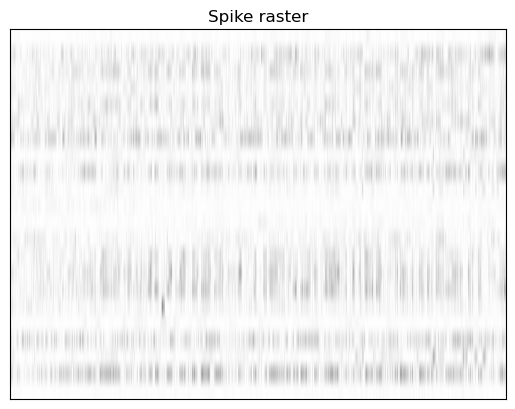

<Axes: title={'center': 'Spike raster'}>

In [7]:
from twop.plots import spike_raster

spike_raster(suite2p_output, title='Spike raster')

### Get a frame dataframe with estimated relative time since t0 and raw scope times in seconds since recording start

In [20]:
frame_df_out = os.path.join(data_basepath, 'frame_df.csv')
frame_df = all_data.make_frame_df(output_csv= False, output_filepath= frame_df_out)
frame_df

,timeEst,frame_time
0,0.000000,40.64420
1,0.732064,41.37605
2,1.464129,42.10800
3,2.196193,42.83995
4,2.928258,43.57190
...,...,...
10395,7609.809663,7649.32815
10396,7610.541728,7650.06010
10397,7611.273792,7650.79205
10398,7612.005857,7651.52400


### Ex. get raw facemap dict output

In [21]:
all_data.facemap_data

{'filenames': [['/mnt/Batista_Lab/Arenski/2p_22q_lamp5/WT7628/WT7628_day1/WT7628_10_21_24_Lamp5GCamp_V1_MMN/WT7628_10_21_24_Lamp5GCamp_V1_MMN_face_2024-10-21-155230-0000.avi']],
 'save_path': '/mnt/Batista_Lab/Arenski/2p_22q_lamp5/WT7628/WT7628_day1/WT7628_10_21_24_Lamp5GCamp_V1_MMN',
 'Ly': [482],
 'Lx': [644],
 'sbin': 4,
 'fullSVD': False,
 'save_mat': True,
 'Lybin': array([120], dtype=int32),
 'Lxbin': array([161], dtype=int32),
 'sybin': array([0]),
 'sxbin': array([0]),
 'LYbin': np.int64(120),
 'LXbin': np.int64(161),
 'avgframe': [array([[60.42169 , 53.488995, 49.087685, ..., 51.704308, 51.863434,
          52.164192],
         [48.28631 , 45.272377, 46.113064, ..., 48.88519 , 48.167187,
          49.80181 ],
         [42.576683, 41.035   , 42.309246, ..., 47.097813, 46.018   ,
          46.261753],
         ...,
         [ 9.778375,  9.856188, 10.736375, ..., 35.09162 , 33.840374,
          33.922188],
         [ 9.768187,  9.75    , 10.394625, ..., 35.634   , 34.48281 ,
    

### Get a state dataframe with camera aligned times and state values

In [26]:
#from state.getFacemapData import get_state_df
import state.getFacemapData as fmd
state_dataframe = fmd.get_state_df(all_data.facemap_data, all_data.camera_times, pupil_data=True, treadmill_signal = all_data.treadmill_raw, 
                                   movement_percentile=70, min_duration_s=1.25, min_max_norm=False, annotate_state=True)
state_dataframe.head(5)

Estimated camera FPS ≈ 29.985
Facemap motion signal contains 229244 frames, camera captured 229569 frames.
Threshold for signal 9449.699160553104
motion_bool True ratio: 0.2220508866615266
Threshold for signal 1.255951699294335
Threshold for signal 2306.9980761224006


,time,motion_bool,locomotion_bool,pupil_bool,motion,treadmill,pupil_area,state
0,31.24910,False,False,True,23765.108647,1.254825,2352.800960,unaroused
1,31.28505,False,False,True,23481.521140,1.254753,2352.967889,unaroused
2,31.32125,False,False,True,22929.588151,1.253095,2353.278961,unaroused
3,31.35580,False,False,True,22139.070054,1.255373,2353.692813,unaroused
4,31.38975,False,False,True,21152.590885,1.254287,2354.158383,unaroused


In [29]:
# get dataframe min max normed and annotated with quiet awake as well
state_dataframe_pupil = fmd.get_state_df(all_data.facemap_data, all_data.camera_times, pupil_data=True, treadmill_signal = all_data.treadmill_raw, 
                                   movement_percentile=70, min_duration_s=1.25, min_max_norm=True, annotate_state_with_pupil=True)
state_dataframe_pupil

Estimated camera FPS ≈ 29.985
Facemap motion signal contains 229244 frames, camera captured 229569 frames.
Threshold for signal 9449.699160553104
motion_bool True ratio: 0.2220508866615266
Threshold for signal 1.255951699294335
Threshold for signal 2306.9980761224006


,time,motion_bool,locomotion_bool,pupil_bool,motion,treadmill,pupil_area,state
0,31.24910,False,False,True,0.319375,1.254825,2352.800960,unaroused
1,31.28505,False,False,True,0.313664,1.254753,2352.967889,unaroused
2,31.32125,False,False,True,0.302549,1.253095,2353.278961,unaroused
3,31.35580,False,False,True,0.286630,1.255373,2353.692813,unaroused
4,31.38975,False,False,True,0.266764,1.254287,2354.158383,unaroused
...,...,...,...,...,...,...,...,...
229564,7683.55895,False,False,False,0.364992,1.254160,2048.813287,unaroused
229565,7683.59230,False,False,False,0.420294,1.254227,2028.635212,unaroused
229566,7683.62565,False,False,False,0.467210,1.254046,2011.307293,unaroused
229567,7683.65895,False,False,False,0.501363,1.254448,1998.580542,unaroused


In [30]:
start, end = 1000, 1200
time_range = state_dataframe_pupil[(state_dataframe_pupil['time'] > start) & (state_dataframe_pupil['time'] < end)]
motion = time_range['motion']

print(motion)
np.mean(motion)

29062    0.008184
29063    0.008498
29064    0.008911
29065    0.009386
29066    0.009879
           ...   
35057    0.008033
35058    0.008333
35059    0.008602
35060    0.008810
35061    0.008931
Name: motion, Length: 6000, dtype: float64


np.float64(0.0896526367859135)

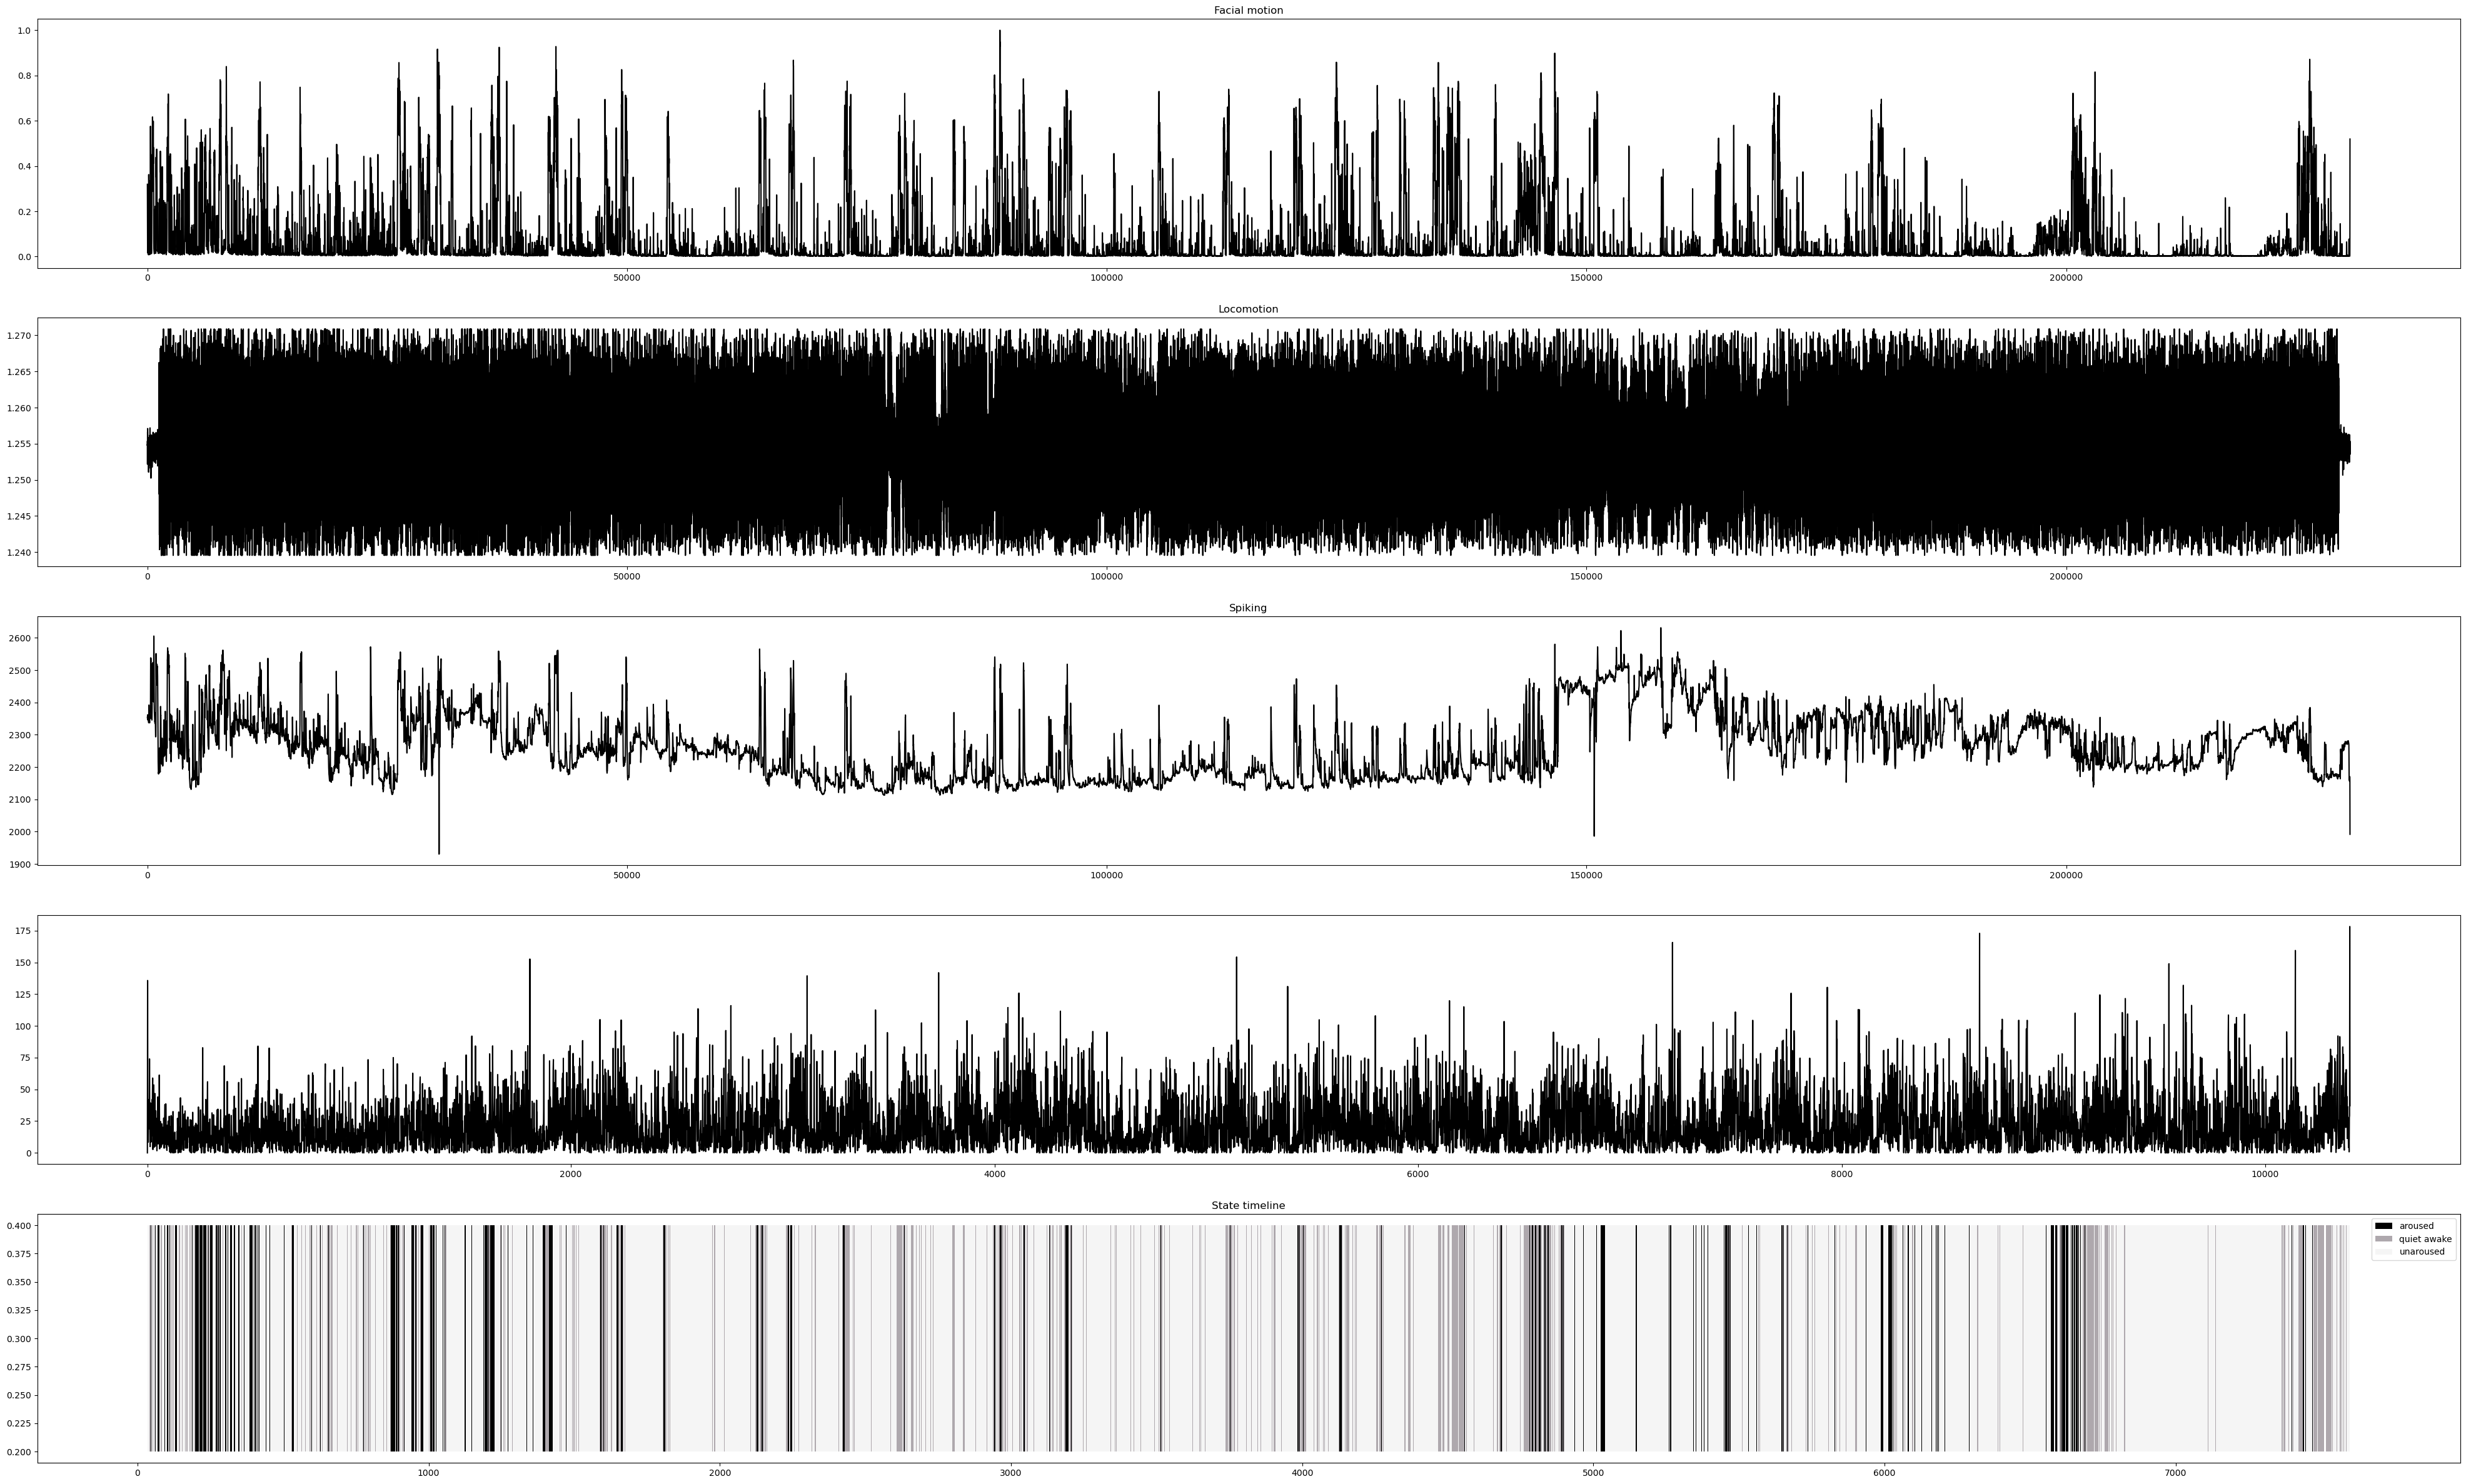

In [40]:
from state.extractStates import plot_state_timeline

plot_state_timeline(state_dataframe_pupil, spikes_arr.mean(axis=0))


### Plot a state timeline

### Get a frame aligned state dataframe, including nearest frames at camera times

In [41]:
frame_state_df = all_data.frame_state_df(state_dataframe)
# to output csv ->
# frame_state_df = all_data.frame_state_df(state_dataframe, output_csv=True)
frame_state_df.head()

,time,nearest_frame_idx,frame_start_time,motion_bool,locomotion_bool,motion,pupil,treadmill
0,31.24910,0,40.6442,False,False,0.319375,0.602582,0.487574
1,31.28505,0,40.6442,False,False,0.313664,0.602820,0.485285
2,31.32125,0,40.6442,False,False,0.302549,0.603264,0.432335
3,31.35580,0,40.6442,False,False,0.286630,0.603854,0.505076
4,31.38975,0,40.6442,False,False,0.266764,0.604518,0.470404
